<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [2]:
!pip install -q catboost

In [8]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
tqdm.pandas()


from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt 


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Подготовка

In [9]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv")

In [10]:
#df = df.sample(10000).reset_index(drop=True)

In [11]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


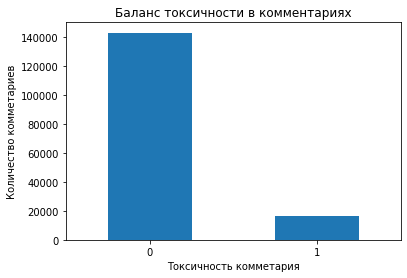

In [13]:
df.toxic.value_counts().plot(kind='bar', rot=0)
plt.xlabel("Токсичность комметария")
plt.ylabel("Количество комметариев")
plt.title("Баланс токсичности в комментариях");

## Обучение

### Подготовка данных

In [71]:
# функция лемматизации

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize(text): 
    # Text input is string, returns lowercased strings.
    return " ".join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))])

In [72]:
#функция очистки комментариев от лишних символов

def clear_text(text):
    pre_clear = re.sub(r"[^a-zA-Z']", ' ', text)
    clear = " ".join(pre_clear.split())
    return clear

In [73]:
df['lemm_text'] = df['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [74]:
df['lemm_text'].head()

0    explanation why the edits make under my userna...
1    d'aww he match this background colour i 'm see...
2    hey man i 'm really not try to edit war it 's ...
3    more i ca n't make any real suggestion on impr...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object

In [75]:
features = df['lemm_text'].values
target = df['toxic']

In [76]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.10, random_state=12345
)

In [77]:
# соотношение выборок по объему
print(f"features_train = {100*len(features_train)/len(df):.2f}%")
print(f"features_test = {100*len(features_test)/len(df):.2f}%")

features_train = 90.00%
features_test = 10.00%


In [78]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
count_tf_idf = TfidfVectorizer(stop_words = list(stopwords))

tf_idf_train = count_tf_idf.fit_transform(features_train)

In [80]:
tf_idf_test = count_tf_idf.transform(features_test)

In [83]:
print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (143362, 147015)
Размер матрицы: (15930, 147015)


### RandomForestClassifier

In [84]:
%%time

RFC = RandomForestClassifier(random_state=12345, class_weight='balanced')
parametrs = {'max_depth': [1,10],'n_estimators': [100,150,10]}


RFC_grid = GridSearchCV(RFC, parametrs, n_jobs=-1, cv=9, scoring='f1')
RFC_grid.fit(tf_idf_train, target_train)

CPU times: user 12min 28s, sys: 3.07 s, total: 12min 31s
Wall time: 12min 32s


GridSearchCV(cv=9,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             scoring='f1')

In [85]:
result_RFC = RFC_grid.best_score_
print(f"F1 RandomForestClassifier: {result_RFC:.3f}")

F1 RandomForestClassifier: 0.351


### LogisticRegression

In [86]:
%%time

model_LR = LogisticRegression(class_weight='balanced', C=15, random_state=12345)
result_LR = cross_val_score(model_LR, 
                      tf_idf_train, 
                      target_train, 
                      cv=9, 
                      scoring='f1').mean()
print(f'F1 LogisticRegression: {result_LR:.3f}')

F1 LogisticRegression: 0.759
CPU times: user 2min 36s, sys: 4min 58s, total: 7min 35s
Wall time: 7min 35s


Изначально предполагалось подбирать гридом два параметра, но время вычисления это просто какая-то шутка. Курс по оптимизации ресурсов и обучению моделей будет?

### CatBoostClassifier

In [60]:
# model = CatBoostClassifier(iterations = 200, learning_rate = 0.5, eval_metric = 'F1', verbose = 20, depth = 10, random_state = 12345)

CBC = CatBoostClassifier(eval_metric = 'F1', 
                         random_state=12345,
                         verbose=1000,
                         iterations = 200,
                         auto_class_weights='Balanced',
                         learning_rate = 0.5)
parameters_CBC = {'depth':[5,10]}
CBC_grid = CBC.grid_search(parameters_CBC,
            Pool(tf_idf_train, target_train), cv=9)

0:	learn: 0.4359135	test: 0.4256365	best: 0.4256365 (0)	total: 282ms	remaining: 56.1s
199:	learn: 0.9999243	test: 0.7673919	best: 0.7983331 (51)	total: 37.9s	remaining: 0us

bestTest = 0.7983331184
bestIteration = 51

0:	loss: 0.7983331	best: 0.7983331 (0)	total: 39.6s	remaining: 39.6s
0:	learn: 0.7050429	test: 0.6566537	best: 0.6566537 (0)	total: 2.88s	remaining: 9m 32s
199:	learn: 1.0000000	test: 0.7460286	best: 0.7749442 (28)	total: 9m 36s	remaining: 0us

bestTest = 0.7749442369
bestIteration = 28

1:	loss: 0.7749442	best: 0.7983331 (0)	total: 10m 15s	remaining: 0us
Estimating final quality...
Training on fold [0/9]
0:	learn: 0.3455693	test: 0.2393162	best: 0.2393162 (0)	total: 222ms	remaining: 44.1s
199:	learn: 1.0000000	test: 0.7442726	best: 0.7837572 (60)	total: 35s	remaining: 0us

bestTest = 0.7837571732
bestIteration = 60

Training on fold [1/9]
0:	learn: 0.3662717	test: 0.3374612	best: 0.3374612 (0)	total: 240ms	remaining: 47.8s
199:	learn: 0.9999303	test: 0.8373588	best: 0.85

In [61]:
CBC_grid['params']

{'depth': 5}

In [62]:
cat_results = pd.DataFrame(CBC_grid['cv_results'])

idx = cat_results['test-F1-mean'].argmax()

cat_results.iloc[idx, :]

iterations            59.000000
test-F1-mean           0.801739
test-F1-std            0.025275
train-F1-mean          0.980117
train-F1-std           0.001223
test-Logloss-mean      0.386944
test-Logloss-std       0.033473
train-Logloss-mean     0.189592
train-Logloss-std      0.003181
Name: 59, dtype: float64

In [88]:
# поместим полученный результаты в таблицу
compare = {
    'model':['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier',],
    'F1':[0.351,0.759,0.802],
    'Wall time, sec': [752,455, 14400]
    }
pd.DataFrame(compare)    

,model,F1,"Wall time, sec"
0,RandomForestClassifier,0.351,752
1,LogisticRegression,0.759,455
2,CatBoostClassifier,0.802,14400


**Вывод**

Лучший результат показала модель `CatBoostClassifier`.

## Тестирование

In [89]:
model_CBC = CatBoostClassifier(iterations = 200, 
                               learning_rate = 0.5, 
                               eval_metric = 'F1', 
                               verbose = 20,
                               depth = 5,
                               auto_class_weights='Balanced',                               
                               random_state = 12345)
model_CBC.fit(tf_idf_train, target_train)
print('F1 мера лучшей модели на тестовых данных:', f1_score(target_test, model_CBC.predict(tf_idf_test)))

0:	learn: 0.4489142	total: 2.55s	remaining: 8m 27s
20:	learn: 0.8281656	total: 43.7s	remaining: 6m 12s
40:	learn: 0.8687080	total: 1m 23s	remaining: 5m 22s
60:	learn: 0.8879719	total: 2m 2s	remaining: 4m 38s
80:	learn: 0.8978317	total: 2m 40s	remaining: 3m 55s
100:	learn: 0.9074320	total: 3m 19s	remaining: 3m 15s
120:	learn: 0.9147580	total: 3m 57s	remaining: 2m 35s
140:	learn: 0.9201326	total: 4m 36s	remaining: 1m 55s
160:	learn: 0.9231824	total: 5m 14s	remaining: 1m 16s
180:	learn: 0.9281309	total: 5m 52s	remaining: 37s
199:	learn: 0.9329507	total: 6m 27s	remaining: 0us
F1 мера лучшей модели на тестовых данных: 0.7351821642196845


In [90]:
model_LR = LogisticRegression(class_weight='balanced', C=15, random_state=12345)
model_LR.fit(tf_idf_train, target_train)

predicted_test_LR = model_LR.predict(tf_idf_test)
result_LR = f1_score(target_test, predicted_test_LR)
print(f"F1 LogisticRegression: {result_LR:.3f}")

F1 LogisticRegression: 0.757


## Выводы

Работа содержит этапы:

* загрузка и подготовка данных
* анализ
* обучение моделей с различными гиперпараметрами
* валидация лучшей модели

Лучший результат показала модель CatBoostClassifier. Но она не прошла тест показав результат **f1** = 0.735.


Таким образом, наша модель это `LogisticRegression`, на тесте она показала результат **f1** = 0.757. К тому же обучение этой модели заняло около 8 минут, в то время как обучение CatBoostClassifier заняло более 4х часов.

Отдельно хочется написать вывод о том, насколько тяжело было писать данный проект. Понятное дело, что объемная тема и сложный материал и т.д. и т.п. но не НАСТОЛЬКО же. 

Каждый шаг сопровождается проблемой и борьбой. Хотел обучить BERT – оказалось слишком сложно, не хватило учебных материалов и времени для поиска необходимых. Решил обучить то, что уже известно – сыпется Jupiter от объёма исходных данных, пришлось разбираться как работает colab, к которому, кстати, так и не удалось прикрутить GPU мощности. Запустил colab – сыпется и он, потому что не хватает бесплатных вычислительных мощностей. В итоге пришлось обучаться на урезаннных данных и вычислять лучшие гиперпараметры, чтобы потом запустить на них catboost на полных данных. 

Уверен, что где-то в интернете есть инфа, как гонять такие массивы данных и не ждать 5 часов, пока модели обучатся на скудных гигах моего ноута, но хочется инструкции от людей, которые принимают участие в обучении.

Отдельно стоит риторический вопрос, зачем криво-косо в жуткой спешке успеть к дедлайнам обучать собсвенные модели по токсик комментам, если на `huggingface` есть модель по анализу токсик комментов.